# Process the NYC House Value data from Zillow and Dept of Finance NYC  
Zhonghan (Jonas) Xie  
Data source: [Zillow](https://www.zillow.com/research/data/?msockid=38d5e17d86ff660f269ef545876967bd)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nyc_neighbor_HVI_long = pd.read_csv("./data/nyc_neighbor_HVI.csv.gz", compression="gzip")

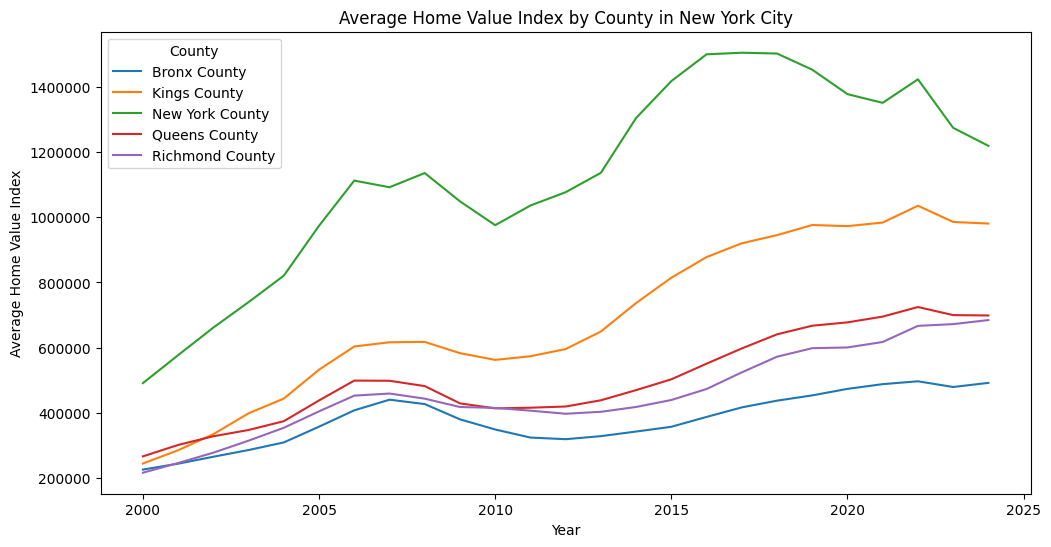

In [4]:
# Calculate the average HVI for each County by year
nyc_county_HVI_avg = (
    nyc_neighbor_HVI_long.groupby(["CountyName", "Year"]).agg({"HVI": "mean"}).reset_index()
)

# Plot the average HVI for each County by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=nyc_county_HVI_avg, x="Year", y="HVI", hue="CountyName")
plt.title("Average Home Value Index by County in New York City")
plt.xlabel("Year")
plt.ylabel("Average Home Value Index")
plt.ticklabel_format(style="plain", axis="y")
plt.legend(title="County")
# plt.grid(True)
plt.show()

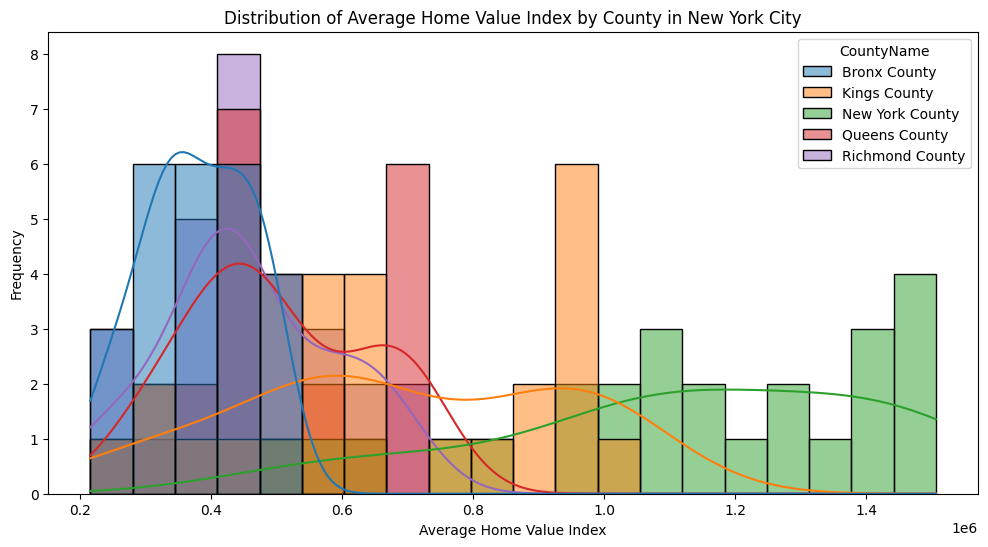

In [5]:
# Plot the histogram of the average HVI for each County
plt.figure(figsize=(12, 6))
sns.histplot(data=nyc_county_HVI_avg, x="HVI", hue="CountyName", bins=20, kde=True)
plt.title("Distribution of Average Home Value Index by County in New York City")
plt.xlabel("Average Home Value Index")
plt.ylabel("Frequency")
plt.show()

In [6]:
nyc_county_HVI_avg.head()

,CountyName,Year,HVI
0,Bronx County,2000,224911.095771
1,Bronx County,2001,243062.045115
2,Bronx County,2002,264350.206288
3,Bronx County,2003,285005.490784
4,Bronx County,2004,308358.040959


In [7]:
# write the data to a csv file
nyc_county_HVI_avg.to_csv("./data/nyc_county_HVI_avg.csv.gz", index=False, compression="gzip")

In [8]:
nyc_neighbor_HVI_long.sample(5)

,RegionID,RegionName,CountyName,Date,HVI,Year
58812,50348,Cambria Heights,Queens County,2024-08-31,666636.884089,2024
38665,4819,Fresh Meadows,Queens County,2016-03-31,719432.146370,2016
39277,270812,Castle Hill,Bronx County,2016-06-30,381994.799723,2016
38500,275247,Rosedale,Queens County,2016-02-29,441678.291073,2016
18094,270844,Gerritsen Beach,Kings County,2007-07-31,371903.958397,2007


## Processing Neighborhood-level Zillow HVI Data

In [21]:
neighborhood = pd.read_csv("./data/zillow_HVI_neighborhood.csv.gz", compression="gzip")
neighborhood = neighborhood[neighborhood["City"] == "New York"]
neighborhood.drop(
    ["RegionID", "RegionType", "State", "StateName", "City", "Metro"], axis=1, inplace=True
)
neighborhood["Neighborhood"] = neighborhood["RegionName"].str.upper()
neighborhood.rename(columns={"CountyName": "Borough"}, inplace=True)

In [25]:
neighborhood.sample(5)

,SizeRank,RegionName,Borough,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,Neighborhood
73,73,Far Rockaway,Queens County,214543.887517,216103.950301,218115.985035,221370.317207,223954.216718,225730.286879,226954.497446,...,6.300489e+05,6.318703e+05,6.346667e+05,6.388612e+05,6.415357e+05,6.421122e+05,6.409501e+05,6.416693e+05,6.451334e+05,FAR ROCKAWAY
766,801,Greenwood,Kings County,191468.884959,192378.113117,193953.612485,196876.535157,199980.476223,201798.269164,202853.625829,...,1.036866e+06,1.041510e+06,1.050267e+06,1.056021e+06,1.059720e+06,1.055894e+06,1.055511e+06,1.058741e+06,1.064394e+06,GREENWOOD
62,62,Bay Ridge,Kings County,311103.163466,312604.295473,314483.840528,318161.024051,322212.716528,325873.824541,329929.109411,...,7.198156e+05,7.191889e+05,7.226448e+05,7.269514e+05,7.322943e+05,7.331268e+05,7.348439e+05,7.374110e+05,7.400639e+05,BAY RIDGE
12990,14753,Lighthouse Hill,Richmond County,313234.387206,317833.898109,320762.273758,327749.476633,334782.587832,342706.145337,350554.436279,...,1.115996e+06,1.118661e+06,1.125046e+06,1.133838e+06,1.142765e+06,1.146044e+06,1.145807e+06,1.146537e+06,1.150880e+06,LIGHTHOUSE HILL
1612,1681,Red Hook,Kings County,152127.337293,150345.410455,149109.072969,149923.775011,151654.047791,153430.262327,153579.544387,...,1.783429e+06,1.795009e+06,1.810215e+06,1.818934e+06,1.824120e+06,1.810209e+06,1.804125e+06,1.804990e+06,1.815702e+06,RED HOOK


In [26]:
# Transform the data from wide to long format
neighbor_long = neighborhood.melt(
    id_vars=["Neighborhood", "Borough", "SizeRank", "RegionName"], var_name="Time", value_name="HVI"
)

# Transform the time to date format and extract the year
neighbor_long["Time"] = pd.to_datetime(neighbor_long["Time"], format="%Y-%m-%d")
neighbor_long["Year"] = neighbor_long["Time"].dt.year

neighbor_hvi_agg = neighbor_long.groupby(["Borough", "Neighborhood", "RegionName", "Year"]).agg({"HVI": "mean"}).reset_index()

neighbor_hvi_agg.sample(5)

,Borough,Neighborhood,RegionName,Year,HVI
1988,New York County,FINANCIAL DISTRICT,Financial District,2013,1.439109e+06
1871,Kings County,WINGATE,Wingate,2021,7.048628e+05
2988,Queens County,FRESH MEADOWS,Fresh Meadows,2013,5.642903e+05
203,Bronx County,EASTCHESTER,Eastchester,2003,2.498044e+05
1980,New York County,FINANCIAL DISTRICT,Financial District,2005,NaN


In [27]:
# Process specific neighborhoods to match the DOF data
## Combine the NORWOOD and BEDFORD PARK, calculate the combined HVI each year
norwood_bedford = neighbor_hvi_agg[neighbor_hvi_agg['Neighborhood'].isin(['NORWOOD', 'BEDFORD PARK'])]
norwood_bedford = norwood_bedford.groupby(['Year']).agg({'HVI': 'mean'}).reset_index()
norwood_bedford['Neighborhood'] = 'BEDFORD PARK/NORWOOD'
norwood_bedford['Borough'] = 'Bronx County'

## Combine CONCOURSE and MELROSE
concourse_melrose = neighbor_hvi_agg[neighbor_hvi_agg['Neighborhood'].isin(['CONCOURSE', 'MELROSE'])]
concourse_melrose = concourse_melrose.groupby(['Year']).agg({'HVI': 'mean'}).reset_index()
concourse_melrose['Neighborhood'] = 'MELROSE/CONCOURSE'
concourse_melrose['Borough'] = 'Bronx County'

## Combine MORRIS PARK and VAN NEST
morris_park_van_nest = neighbor_hvi_agg[neighbor_hvi_agg['Neighborhood'].isin(['MORRIS PARK', 'VAN NEST'])]
morris_park_van_nest = morris_park_van_nest.groupby(['Year']).agg({'HVI': 'mean'}).reset_index()
morris_park_van_nest['Neighborhood'] = 'MORRIS PARK/VAN NEST'
morris_park_van_nest['Borough'] = 'Bronx County'

## Combine MORRIS HEIGHTS and HIGHBRIDGE
morris_heights_highbridge = neighbor_hvi_agg[neighbor_hvi_agg['Neighborhood'].isin(['MORRIS HEIGHTS', 'HIGHBRIDGE'])]
morris_heights_highbridge = morris_heights_highbridge.groupby(['Year']).agg({'HVI': 'mean'}).reset_index()
morris_heights_highbridge['Neighborhood'] = 'HIGHBRIDGE/MORRIS HEIGHTS'
morris_heights_highbridge['Borough'] = 'Bronx County'

# add to the original data
neighbor_hvi_agg = pd.concat([neighbor_hvi_agg, norwood_bedford, concourse_melrose, morris_park_van_nest, morris_heights_highbridge], ignore_index=True)

In [28]:
# Read in DOF neighborhood sales data
neighbor_sales = pd.read_csv("./data/DOF_Summary_of_Neighborhood_Sales.csv")

neighbor_sales.sample(5)

# Aggregate the sales data by neighborhood and year
neighbor_sales_agg = (
    neighbor_sales.groupby(["NEIGHBORHOOD", "YEAR"]).agg(
        {
            "NUMBER OF SALES": "sum",
            "AVERAGE SALE PRICE": "mean",
            "MEDIAN SALE PRICE": "median",
            "LOWEST SALE PRICE": "min",
            "HIGHEST SALE PRICE": "max",
        }
    ).reset_index()
)

# Change the column names to capital the first letter
neighbor_sales_agg.columns = [
    col.title() for col in neighbor_sales_agg.columns
]

neighbor_sales_agg.sample(5)

,Neighborhood,Year,Number Of Sales,Average Sale Price,Median Sale Price,Lowest Sale Price,Highest Sale Price
2763,UPPER WEST SIDE (96-116),2011,1,4.050000e+06,4050000.0,4050000,4050000
2408,SCHUYLERVILLE/PELHAM BAY,2013,107,4.190613e+05,425000.0,212000,742000
1305,HARLEM-EAST,2014,16,1.248374e+06,1210000.0,670000,2200000
655,CORONA,2013,184,5.533603e+05,560000.0,203000,1360000
2503,SOUTH BEACH,2017,164,5.747427e+05,594444.0,200000,940000


In [29]:
# Merge with neighborhood mapping
neighbor_map = pd.read_csv("./data/neighborhood_mapping.csv")
neighbor_sales_merged= pd.merge(neighbor_map, neighbor_sales_agg, left_on="dof_name", right_on="Neighborhood")


In [31]:
neighbor_sales_merged= pd.merge(neighbor_sales_merged, neighbor_hvi_agg, left_on=["zillow_name", "Year"], right_on=["RegionName", "Year"])

In [32]:
neighbor_sales_merged.columns

Index(['nta_code', 'nta_name', 'dof_name', 'zillow_name', 'borough',
       'Neighborhood_x', 'Year', 'Number Of Sales', 'Average Sale Price',
       'Median Sale Price', 'Lowest Sale Price', 'Highest Sale Price',
       'Borough', 'Neighborhood_y', 'RegionName', 'HVI'],
      dtype='object')

In [33]:
neighbor_sales_clean = neighbor_sales_merged[
    [
        "nta_code",
        "nta_name",
        "dof_name",
        "RegionName",
        "borough",
        "Year",
        "Number Of Sales",
        "Average Sale Price",
        "Median Sale Price",
        "Lowest Sale Price",
        "Highest Sale Price",
        "HVI"
    ]
]

neighbor_sales_clean.columns = [
    "nta_code",
    "nta_name",
    "dof_name",
    "neighborhood",
    "borough",
    "year",
    "number_of_sales",
    "average_sale_price",
    "median_sale_price",
    "lowest_sale_price",
    "highest_sale_price",
    "hvi"
]

In [34]:
neighbor_sales_clean.to_csv("./data/cleaned_neighbor_sales.csv", index = False)

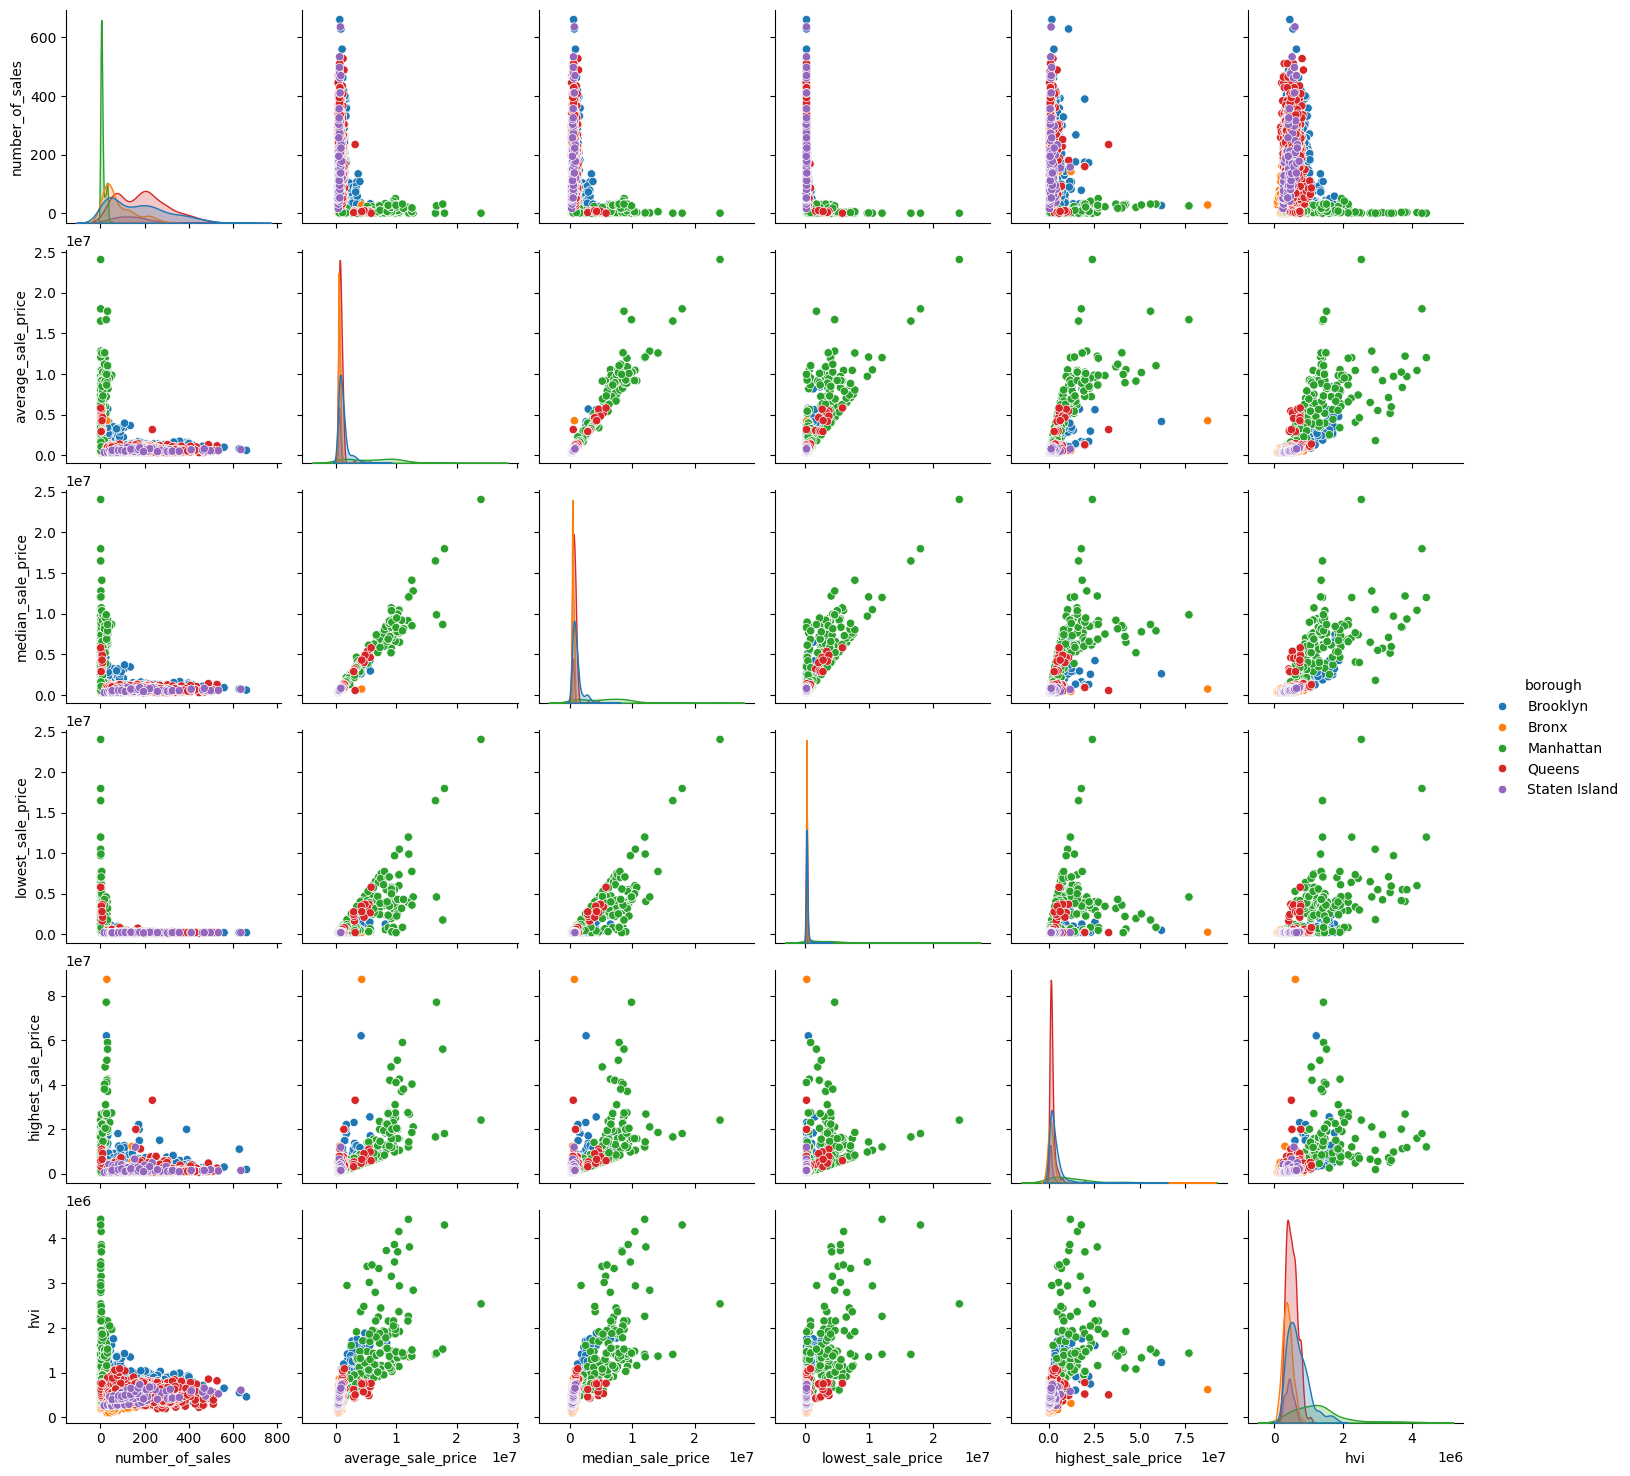

In [36]:
# Draw a pairplot to check the relationship between the sales data and HVI
feature = ["number_of_sales", "average_sale_price", "median_sale_price", "lowest_sale_price", "highest_sale_price", "hvi"]
sns.pairplot(neighbor_sales_clean, vars=feature, hue="borough", diag_kind="kde")

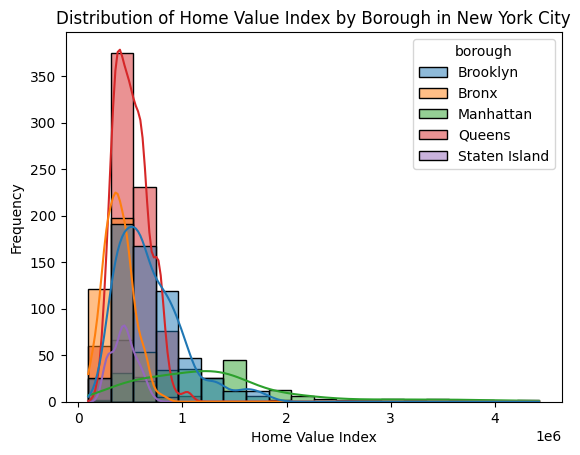

In [37]:
sns.histplot(data=neighbor_sales_clean, x="hvi", hue="borough", bins=20, kde=True)
plt.title("Distribution of Home Value Index by Borough in New York City")
plt.xlabel("Home Value Index")
plt.ylabel("Frequency")
plt.show()